## Segmentation of oil in a microfluidic device

Lucas Mejia (LM34735)

### Executive Summary


In our lab, we have use a simple thresholding method to segment phases in images when using a handheld camera. Can we do better (segment phases more accurately) using a Naive Bayes classifier? I used a Naive Bayes classifier to determine if our current image processing workflow could be enhanced - i.e if we could get better fraction measurements using an NB classifier than from by traditional image processing. I learned that by using the classifier, I do better at segmenting pictures with lightning conditions similar to those I sampled, but worse for other lighting conditions. Most importantly, from visualization of the second segmented image with different light, I identified the probable source of error caused by selective sampling: pixels that are classified as oil but are not oil. They are surrounded by oil and hence appear darker on camera. I speculate these errors may be addressed with machines that incorporate structural relationships/interactions such as neural networks, which is exciting future work for me.

You can download the repository to obtain the data:
https://github.com/lmkerguelen/SubsurfaceMachineLearningProject

In [17]:
import numpy as np                        # use nd arrays
import pandas as pd                       # use dataframes
import matplotlib.pyplot as plt           # for plotting
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from sklearn.model_selection import train_test_split        # train and test split
import geostatspy.geostats as geostats    # GSLIB methods convert to Python   
from sklearn.naive_bayes import GaussianNB                  # naive Bayes model and prediction

### Functions

In [18]:
#From Pyrcz's github, useful for visualizing the model
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    cmap = plt.cm.plasma    
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])      # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels = 50) # plot the predictions
    # add the data values as a colored by response feature scatter plot
    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)                                       # add the labels
    plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max])
    cbar = plt.colorbar(im, orientation = 'vertical')      # add the color bar
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
    return(plt)
    
#calculate fraction for pixels with integer values
def saturation(image):
    oilpixels=np.count_nonzero(image < 1)
    totalpixels=image.size
    sat = oilpixels/totalpixels
    return sat

#invert binary image
def bin_invert(image):
    inverted=np.where((image==0)|(image==1), image^1, image)
    return inverted

#prepare rgb image (in bgr, which is OpenCV's default format) for model inputting
def prep_image(img):
    b, g, r    = cv2.split(img) # Split the channels to use two of them as predictor features
    b_flat = b.flatten() #flat b_channel
    r_flat = r.flatten() #flat r_channel
    X=np.vstack((r_flat,b_flat))
    X=X.T #Image is now an n x 2 matrix (with the b and r channels)
    return b, g, r, X


### Load Data

In [19]:
my_data1 = pd.read_csv('oil_pixels.csv')      # import the sampling of oil pixels
my_data2 = pd.read_csv('notoil_filtered.csv') # import sampling of notoil pixels: this includes aqueous phase and solid phase
my_data3 = pd.read_csv('notOil2.csv')
my_data4 = pd.read_csv('oilpixels2.csv')
allsamples = [my_data2, my_data1, my_data3, my_data4];
df = pd.concat(allsamples)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r,1050.0,126.604762,24.128726,81.0,100.00,137.0,147.0,166.0
g,1050.0,135.173333,26.536240,89.0,106.00,147.0,159.0,176.0
b,1050.0,135.354286,31.854684,79.0,101.25,150.0,165.0,184.0
phase,1050.0,0.471429,0.499421,0.0,0.00,0.0,1.0,1.0


I did two rounds of sampling (one round consisted of getting oil pixels, then not-oil pixels in two .csv files), which is why I had four input files.

I sampled 1050 pixels total, about half were oil and half were not-oil.

In [20]:
x1min=80
x1max=170
x2min=70
x2max=190

### Data Checking and Visualization

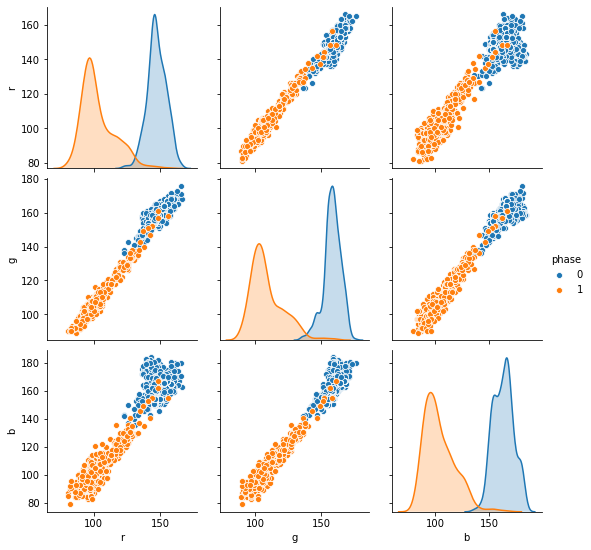

In [21]:
sns.pairplot(df,vars=['r','g','b'],markers='o',hue='phase')

Ocular inspection tells me I can segment phases pretty much using any of the bivariate distributions (maybe even univariate). I will use two of the three pixel channels as predictor features for adequate information inclusion and ease of visualization. Extensive feature ranking (using partial correlation, mutual information, and a random forest classifier, not included for brevity but shown in a previous iteration of the project) indicated the blue and red channels had the most information, so I will work with those as predictor features moving forward. 

In [22]:
#split the data (30% for testing, 70% for training)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,[0,2]], df.iloc[:,3], test_size=0.3, random_state=100)
y_train = pd.DataFrame({'phase':y_train.values})
y_test = pd.DataFrame({'phase':y_test.values})

In [23]:
priors = (0.5,0.5)   #naive priors should be ok, since the fraction of phases is also around 50%
gnb = GaussianNB(priors = priors)   # instantiate the GNB using sklearn
GaussianNB_fit = gnb.fit(X_train,y_train['phase'].values) #train the model

y_pred = GaussianNB_fit.predict(np.c_[X_test['r'].values,X_test['b'].values]) # predict over the testing data

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test['phase'].values, y_pred, labels=[0,1]))
print(confusion_matrix(y_test['phase'].values, y_pred))
#looks loke we do quite well for this case, most are correctly classified

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       168
           1       1.00      0.99      0.99       147

    accuracy                           0.99       315
   macro avg       0.99      0.99      0.99       315
weighted avg       0.99      0.99      0.99       315

[[168   0]
 [  2 145]]


The model performed quite well on the testing data, with an f1-score of 99% when classifying both phases. However, recall is slightly lower when predicting phase 1 (oil) than phase 0 (not-oil). This suggests we might get a larger number of not-oil pixels put into the oil class than oil pixels into the not-oil class.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  # This is added back by InteractiveShellApp.init_path()


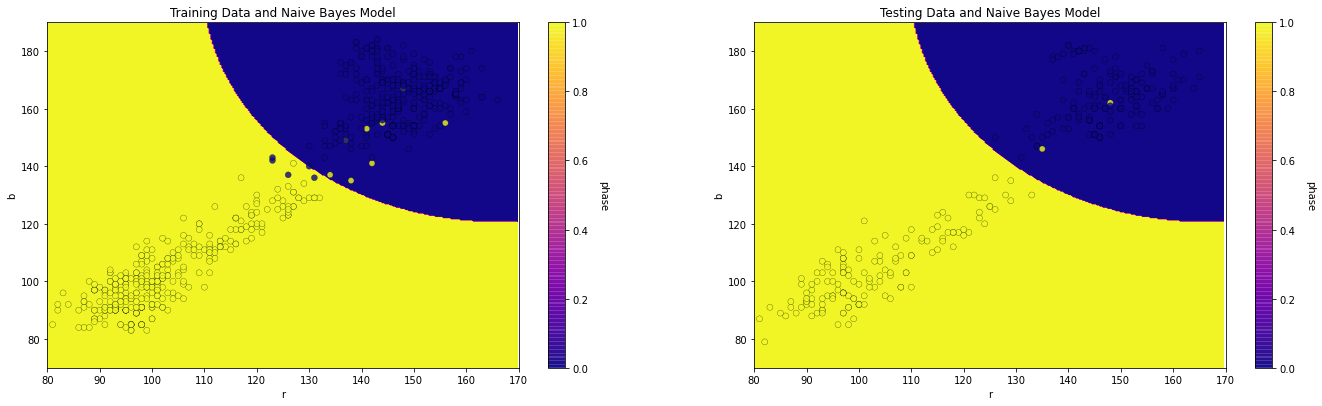

In [25]:
#visualization of training and testing with model in predictor feature space
plt.subplot(1,2,1)
visualize_model(GaussianNB_fit,X_train["r"],x1min,x1max,X_train["b"],x2min,x2max,y_train['phase'],0.0,1.0,'Training Data and Naive Bayes Model')
plt.subplot(1,2,2)
visualize_model(GaussianNB_fit,X_test["r"],x1min,x1max,X_test["b"],x2min,x2max,y_test['phase'],0.0,1.0,'Testing Data and Naive Bayes Model')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)

The model splits the data at approximately where I expected from ocular inspection of vibariate plots. The two misclassified examples on testing are evident on the plot on the right. From the training visualization, we expect a few more misclassifications when segmenting a real image than those we had during testing.

In [26]:
import cv2 #load openCV library
#read in images
im = cv2.imread('region5_camera.tiff')
im_micro = cv2.imread('region5_microscope.tiff')
im_micro_segmented = cv2.imread('region5_microscope_segmented.tiff')
sat_tru = 34.783

print (type(im))
print(im.shape)

<class 'numpy.ndarray'>
(581, 961, 3)


Here we loaded an image to use the classifier on (region5_camera.tif) and another image which captured the same region but using microscopy (region5_microscope.tif). The segmented version of the latter (region5_microscope_segmented.tif) was also uploaded and will be used as a 'truth' comparison point. Fraction of the segmented image was calculated by applying Otsu thresholding after image processing on the open source software ImageJ. True oil fraction was 34.783.

In [27]:
b, g, r, X = prep_image(im) #this function returns each channel as an nxm array and the whole
                            #image as an (nxm)x1 vector

In [28]:
#pass the image to the trained model
segmented_im = GaussianNB_fit.predict(X) #predict using trained model
reshaped=segmented_im.reshape(b.shape[0],b.shape[1]) #reshape the flat vector to a 2D array for display
inverted = bin_invert(reshaped)#now let's invert the image so that format is consistent with cv2 thresholding

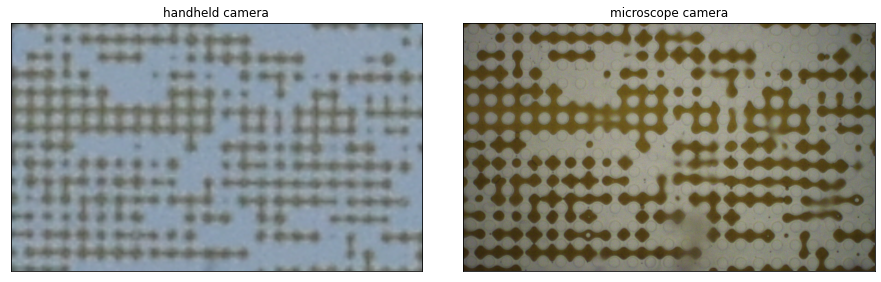

In [29]:
#Let's visualize the original images (camera picture, and 'truth' from microscope)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) #convert to RGB for display
im_micro_rgb = cv2.cvtColor(im_micro, cv2.COLOR_BGR2RGB) #convert to RGB for display

plt.subplot(1,2,1)
plt.imshow(im_rgb)
plt.title('handheld camera')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplot(1,2,2)
plt.imshow(im_micro_rgb)
plt.title('microscope camera')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplots_adjust(left=0.0, right=2.0, bottom = 0.0, top = 1, wspace=0.1, hspace=0.1)

We can see the handheld camera image is quite blurry compared to the microscope image. The colors have good spatial correspondence, so hopefully the classifier will work well.

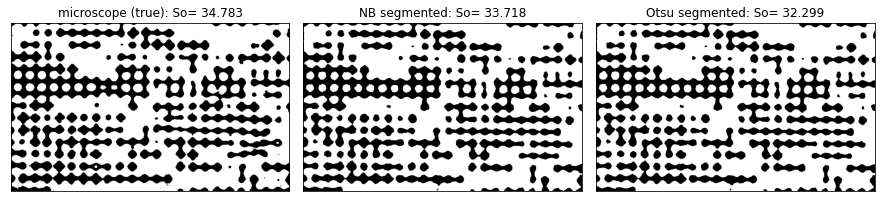

In [30]:
#segment handheld camera image with otsu using OpenCV library
img2=cv2.imread("region5_camera.tiff",0)
ret2,otsu = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.subplot(1,3,1)
plt.imshow(im_micro_segmented)
plt.title('microscope (true): So= %1.3f' % sat_tru)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplot(1,3,2)
plt.imshow(inverted, cmap=plt.cm.gray)
plt.title('NB segmented: So= %1.3f' % (100.*saturation(inverted)))
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplot(1,3,3)
plt.imshow(otsu, cmap=plt.cm.gray)
plt.title('Otsu segmented: So= %1.3f' % (100.*saturation(otsu)))
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplots_adjust(left=0.0, right=2.0, bottom = 0.0, top = 0.8, wspace=0.05, hspace=0.01)

The NB classifier performs a little better than the Otsu segmentation, but both are off by very little. Qualitatively, the NB and Otsu segmented look very similar to the microscope image. Interface edges on both (NB and Otsu) look less well defined than than interfaces in the microscope, but that is expected as NB and Otsu were derived off a low resolution images.

In [31]:
#let's try another photo from another experiment
#read in image, apply NB model, reshape for visualization
region1 = cv2.imread('region1_camera2.tiff')
br1, gr1, rr1, Xr1 = prep_image(region1)
segmented_r1 = GaussianNB_fit.predict(Xr1)
reshaped_r1 =segmented_r1.reshape(br1.shape[0],br1.shape[1])
inverted_r1 = bin_invert(reshaped_r1)


region1_rgb = cv2.cvtColor(region1, cv2.COLOR_BGR2RGB) #convert to RGB for display

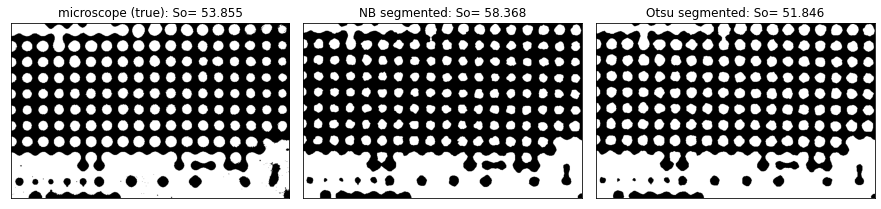

In [32]:
im_micro_r1 = cv2.imread('region1_microscope2_bin.tiff') #read in segmented microscope image
sat_tru_reg1=53.855 #true oil fraction of this second microscope image retrieved from ImageJ

#calculate the oil fraction of handheld camera image using Otsu method
img2=cv2.imread("region1_camera2.tiff",0)
ret2,r1cam = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.subplot(1,3,1)
plt.imshow(im_micro_r1)
plt.title('microscope (true): So= %1.3f' % sat_tru_reg1)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplot(1,3,2)
plt.imshow(inverted_r1, cmap=plt.cm.gray)
plt.title('NB segmented: So= %1.3f' % (100.*saturation(inverted_r1)))
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplot(1,3,3)
plt.imshow(r1cam, cmap=plt.cm.gray)
plt.title('Otsu segmented: So= %1.3f' % (100.*saturation(r1cam)))
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])

plt.subplots_adjust(left=0.0, right=2.0, bottom = 0.0, top = 0.8, wspace=0.05, hspace=0.01)

In this case the NB classifier over-estimates the oil fraction, and Otsu performs better. Qualitatively, both methods capture the shapes well, but the NB classifier identifies the outer edges of grains as oil. It seems the classifier is quite sensitive to image conditions, as the morphology of the chip was the same for both cases. Only light was different from the previous image.